In [1]:
import os
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from PIL import Image

sns.set(style="whitegrid")

In [2]:
# Load dataset samples from .feather file
DATA_PATH = '<PATH-TO-DATASET>'
LABELS_PATH = '<PATH-TO-LABELS>'
DATASET_NAME = '<DATASET-NAME.feather>'

datasetSamples = pd.read_feather(os.path.join(LABELS_PATH, DATASET_NAME))

# Print out some of the data for preview
datasetSamples.head(10)

,Spectrogram,Token
0,103-1240-0000.png,"[5, 10, 3, 18, 22, 7, 20, 1, 17, 16, 7, 1, 15,..."
1,103-1240-0001.png,"[22, 10, 3, 22, 1, 10, 3, 6, 1, 11, 22, 21, 1,..."
2,103-1240-0002.png,"[8, 17, 20, 1, 16, 17, 22, 1, 7, 24, 7, 16, 1,..."
3,103-1240-0003.png,"[3, 16, 6, 1, 22, 10, 3, 22, 1, 11, 8, 1, 21, ..."
4,103-1240-0004.png,"[4, 23, 22, 1, 15, 11, 21, 21, 23, 21, 1, 20, ..."
5,103-1240-0005.png,"[10, 7, 14, 18, 7, 6, 1, 20, 23, 16, 1, 22, 10..."
6,103-1240-0006.png,"[3, 21, 1, 3, 24, 17, 16, 14, 7, 3, 1, 10, 17,..."
7,103-1240-0007.png,"[3, 16, 27, 4, 17, 6, 27, 1, 25, 10, 17, 1, 25..."
8,103-1240-0008.png,"[22, 10, 7, 1, 17, 20, 5, 10, 3, 20, 6, 1, 17,..."
9,103-1240-0009.png,"[15, 11, 21, 21, 23, 21, 1, 20, 3, 5, 10, 7, 1..."


In [3]:
# Extract spectrogram names
spectrograms = datasetSamples['Spectrogram']

print("Dataset size: {}".format(len(spectrograms)))

# Print out some of the spectrogram names
spectrograms.head(5)

Dataset size: 28539


0    103-1240-0000.png
1    103-1240-0001.png
2    103-1240-0002.png
3    103-1240-0003.png
4    103-1240-0004.png
Name: Spectrogram, dtype: object

In [4]:
# Get width of each spectrogram
spectrograms_dict = dict()
spectrograms_width = list()

for spec_name in spectrograms:
    spec = Image.open(os.path.join(DATA_PATH, spec_name))
    width, height = spec.size
    
    if spec_name not in spectrograms_dict:
        spectrograms_dict[spec_name] = width

for value in spectrograms_dict.values():
    spectrograms_width.append(value)

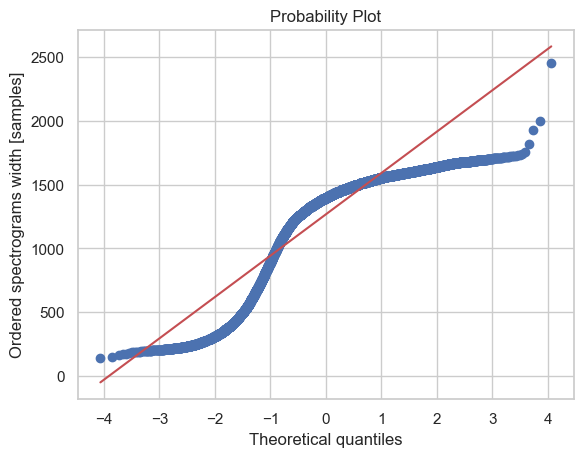

<Figure size 800x400 with 0 Axes>

In [5]:
# OUTLIERS DETECTION

# Check if the data comes from a Normal Distribution using QQ Plot (Quantile-Quantile)
fig, ax = plt.subplots()

qq_plot = stats.probplot(spectrograms_width, dist='norm', plot=plt)

plt.figure(figsize=(8, 4))

ax.set_xlabel("Theoretical quantiles")
ax.set_ylabel("Ordered spectrograms width [samples]")
ax.set_title("Probability Plot")

plt.show()

# The points deviate significantly from the straight diagonal line. 
# This is an indication that the set of spectrograms width is not normally distributed.

In [6]:
# Outlier detection using the Interquartile Range Method (IQR)

# Sort data from low to high
sort_spec_width = sorted(spectrograms_width)

# Identify the first quartile (Q1), the median (Q2) and the third quartile (Q3)
Q1, Q2, Q3 = np.quantile(sort_spec_width, .25), np.quantile(sort_spec_width, .50), np.quantile(sort_spec_width, .75)

# Calculate IQR
IQR = Q3 - Q1

# Calculate upper and lower bounds
lower_bound = np.ceil(Q1 - 1.5 * IQR)
upper_bound = np.floor(Q3 + 1.5 * IQR)

print('--Parameters--',
      'Minimum value: {}'.format(np.min(sort_spec_width)),
      'Maximum value: {}'.format(np.max(sort_spec_width)),
      'Lower bound: {}'.format(lower_bound),
      'Upper bound: {}'.format(upper_bound), sep=os.linesep)

--Parameters--
Minimum value: 138
Maximum value: 2450
Lower bound: 626.0
Upper bound: 2045.0


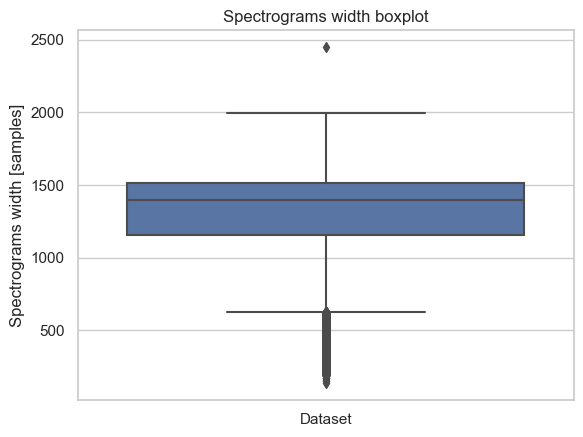

<Figure size 800x400 with 0 Axes>

In [7]:
# Prepare boxplot
fig, ax = plt.subplots()

boxplot = sns.boxplot(sort_spec_width, orient='vertical', whis=1.5, ax=ax)

plt.figure(figsize=(8, 4))

boxplot.set(ylabel='Spectrograms width [samples]', title="Spectrograms width boxplot", xticks=[0], xticklabels=['Dataset'])

plt.show()

In [8]:
# Visual representation - histogram
def prepare_histogram(widths: list, mark_outliers: bool = False) -> (list, list):
    
    # Prepare histogram parameters
    min_val = np.min(widths)
    max_val = np.max(widths)

    observations_num = len(widths)
    observations_range = max_val - min_val

    intervals = int(np.ceil(np.sqrt(observations_num)))
    intervals_width = int(np.ceil(observations_range / intervals))

    hist_bins = list()

    for i in range(intervals):
        hist_bins.append(min_val + intervals_width * i)

    hist, edges = np.histogram(widths, hist_bins)

    plt.figure(figsize=(8, 4))

    plt.bar(hist_bins[:-1], hist, width=intervals_width, align="edge", ec="k")
    
    if mark_outliers:
        plt.axvspan(xmin = lower_bound, xmax= np.min(widths), alpha=0.2, color='red')
        plt.axvspan(xmin = upper_bound, xmax= np.max(widths), alpha=0.2, color='red')

    plt.xlabel('Spectrograms width [samples]')
    plt.ylabel('Number of occurrences')
    plt.title('NumPy barplot - spectrograms width histogram')

    plt.show()
    
    return hist, edges

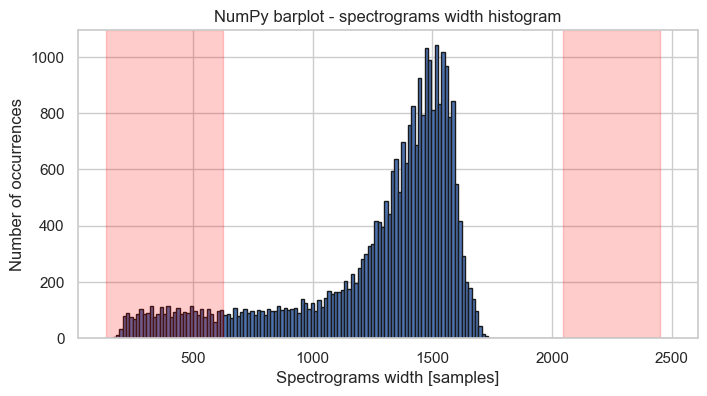

In [9]:
# Prepare histogram with outliers
_, _ = prepare_histogram(spectrograms_width, mark_outliers=True)

In [10]:
# Detect outliers from dataset
IQR_outliers = list()

for name, width in spectrograms_dict.items():
    if width < lower_bound or width > upper_bound:
        IQR_outliers.append(name)

print('Total number of outliers are: {}'.format(len(IQR_outliers)))

Total number of outliers are: 2770


In [11]:
# Remove outliers from dataset
cleaned_spectrograms_dict = dict()
cleaned_spectrograms_width = list()

cleaned_spectrograms_dict = {name: width for name, width in spectrograms_dict.items() if name not in IQR_outliers}

for value in cleaned_spectrograms_dict.values():
    cleaned_spectrograms_width.append(value)

print('Total number of samples in dataset: {}'.format(len(spectrograms_dict)),
      'Number of samples in dataset without outliers: {}'.format(len(cleaned_spectrograms_dict)), sep=os.linesep)

Total number of samples in dataset: 28539
Number of samples in dataset without outliers: 25769


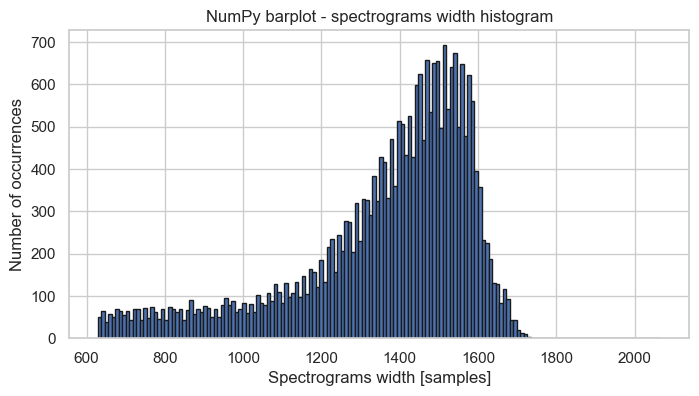

In [12]:
# Prepare histogram for dataset without outliers
hist, edges = prepare_histogram(cleaned_spectrograms_width)

In [13]:
# Analyse frequencies for each bin
hist_dict = dict()
hist_dict = {e: h for e, h in zip(edges, hist) if e not in hist_dict}

hist_df = pd.DataFrame([(edge, freq) for edge, freq in hist_dict.items()],
                                         columns=['Edges', 'Frequency'])

hist_df = hist_df[hist_df['Frequency'] >= 5]

print('Spectrograms width - HEAD', hist_df.head(5), '\n', sep=os.linesep)
print('Spectrograms width - TAIL', hist_df.tail(5), sep=os.linesep)

Spectrograms width - HEAD
   Edges  Frequency
0    628         50
1    637         65
2    646         38
3    655         56
4    664         51


Spectrograms width - TAIL
     Edges  Frequency
117   1681         42
118   1690         44
119   1699         19
120   1708         12
121   1717          9


In [14]:
print('---NEURAL NETWORK - DATASET PARAMETERS---',
      'Specified minimum sequence length: {}'.format(int(lower_bound)),
      'Specified maximum sequence length: {}'.format(hist_df["Edges"].iloc[-1]), sep=os.linesep)

---NEURAL NETWORK - DATASET PARAMETERS---
Specified minimum sequence length: 626
Specified maximum sequence length: 1717
